In [1]:
import json
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
mainfile = "result_2023_6_8.json"
maindata = []
with open(mainfile, 'r') as f:
  for entry in f:
      oneEntry = json.loads(entry)
      maindata.append(oneEntry)

# Data Analysis for JSON Files (draft)
Looking into website leak data from edutech extension. Written up version of exploratory data analysis. <br>
**Mentor:** Jake Chanesson,   **Research Assistant:** Shayona Basu

Data produced by **AirLAB**

### Removing data entries where the json file has no report data saved:

In [3]:
filtered_data = []
for d in maindata: 
  if d.get('report') != None: #not empty
    if d.get('report').get('user_id') != None: 
      filtered_data.append(d)

In [4]:
f"After the initial filtiration there are {len(filtered_data)} entries, when there were initially {len(maindata)} entries"

'After the initial filtiration there are 533229 entries, when there were initially 688185 entries'

I am curious to check what actually consists of empty data. I am defining empty data as data where reports are made, but there is no user_id. I am going to go through and explore what the empty data consists of. I believe this can be useful to understand we are not using, and confirming it is empty. 

In [5]:
empty_data = []
for d in maindata: 
    if d.get('report') != None: 
        if d.get('report').get('user_id') == None:
            empty_data.append(d)
print(f"There are {len(empty_data)} entries of json data with reports but no user")

There are 139405 entries of json data with reports but no user


Printing a random entry of the empty dataset

In [6]:
empty_data[38473]

{'_id': {'$oid': '6445de9372be29a61f7fc1a2'},
 'report': {'user_id': None,
  'school_district': None,
  'grade': None,
  'request_method': 'GET',
  'timestamp': '2023-04-24T01:42:19.457Z',
  'leak_url': 'https://www.google.com/maps/vt/LEAKED_LASTNAME/LEAKED_LASTNAME=LEAKED_LASTNAME/LEAKED_LASTNAMEs/poi/LEAKED_LASTNAME/LEAKED_LASTNAME,LEAKED_LASTNAME/LEAKED_LASTNAMEs/poi/LEAKED_LASTNAME/LEAKED_LASTNAME,LEAKED_LASTNAME/LEAKED_LASTNAMEs/poi/quantum/LEAKED_LASTNAME/lodging_LEAKED_LASTNAME-2-medium.png&LEAKED_LASTNAME=LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAMELEAKED_LASTNAME=LEAKED_LASTNAME',
  'initiator_domain': 'https://www.google.com/',
  'url_leak_type': ['lastname'],
  'body_leak_type': [],
  'tracker_info': {'action': 'ignore',
   'reason': 'first party',
   'firstParty': True,
   'redirectUrl': False,
   'matchedRule': None,
   'matchedRuleException': False,
   'tracker': {'domain': 'google.com',
    'owner': {'name': 'Google LLC',
     'displayName': 'Google',
     'privacyPol

From checking this random entry, we see there is seemingly useful amount of information, so I think we should edit how our first stage of filtering, and potentially include reports where there is no user_id. We can save the data with no user_id, in its own group and continue to do website analysis

In [7]:
print(f'Of all the data entries from the files, the initial filtration removes {round(len(empty_data)/len(maindata) *100,2)}%' )

Of all the data entries from the files, the initial filtration removes 20.26%


In [8]:
filtered_data1 = []
for d in maindata: 
  if d.get('report') != None: #not empty
    if d.get('report').get('initiator_domain') != None: 
        filtered_data1.append(d)

### Not sure what this empty data set is for

In [9]:
filtered_data1_empty = []
for d in maindata: 
  if d.get('report') != None: #not empty
    if d.get('report').get('initiator_domain') == None: 
        filtered_data1.append(d)

I think maybe a better initial filtering would be to remove data where the initiator domain data is not collected. I think now is a good time to define two important cateogires for websites collected, throughout the rest of this data analysis <br>
**Initiator Domain:**   The website where the user lands, where the leak then occurs. 
**Tracker URL:**   The website of which the tracker owns, and where the leak actually happens

Documentation: https://homes.esat.kuleuven.be/~asenol/leaky-forms/ 

In [10]:
print(f'There are {len(filtered_data1)} websites that have the leak origin website data. Accordingly, there were {len(maindata)-len(filtered_data1)} entries, or {round(((len(maindata)-len(filtered_data1))/len(maindata))*100,2)}% removed in this updated initial filtration.')

There are 672634 websites that have the leak origin website data. Accordingly, there were 15551 entries, or 2.26% removed in this updated initial filtration.


### Here is an example entry of the new filtered dataset: 

In [11]:
filtered_data1[200000]

{'_id': {'$oid': '64583ff53d17c352fa865bb5'},
 'report': {'user_id': 'dknglbh1h3',
  'school_district': 'Other',
  'grade': '6',
  'request_method': 'GET',
  'timestamp': '2023-05-08T00:04:12.190Z',
  'leak_url': 'hLEAKED_LASTNAMELEAKED_LASTNAMEps://signaler-pa.clienLEAKED_LASTNAMEs6.google.com/LEAKED_LASTNAME/LEAKED_LASTNAME/LEAKED_LASTNAMELEAKED_LASTNAME=8&LEAKED_LASTNAME=LEAKED_LASTNAME&key=LEAKED_LASTNAME&RID=LEAKED_LASTNAME&SID=LEAKED_LASTNAME&AID=6&LEAKED_LASTNAME=0&LEAKED_LASTNAME=xmlhLEAKED_LASTNAMELEAKED_LASTNAMEp&zx=LEAKED_LASTNAME&LEAKED_LASTNAME=1',
  'initiator_domain': 'https://calendar.google.com/',
  'url_leak_type': ['lastname'],
  'body_leak_type': [],
  'tracker_info': {'action': 'ignore',
   'reason': 'first party',
   'firstParty': True,
   'redirectUrl': False,
   'matchedRule': None,
   'matchedRuleException': False,
   'tracker': {'domain': 'google.com',
    'owner': {'name': 'Google LLC',
     'displayName': 'Google',
     'privacyPolicy': 'https://policies.goo

## Starting the Data Analysis

Now, I will begin to make sense of reduced dataset, `filtered_data1`. As per the definitions a few cells above, I will now go through the filtered data set, and collect the Initiator URL and the Leak URL, and present it in a table.

In [12]:
#Saving Leak_URLS and Origin_URLS
Leak_URLS = []
Origin_URLS = []
for d in filtered_data1: 
    rep = d['report']
    Origin_URLS.append(rep['initiator_domain'])
    if rep.get('tracker_info') != None: 
        #some reports do not have tracker info
        if rep['tracker_info'].get('tracker').get('owner').get('url') != None: 
            #all reports with tracker info, have the following
            Leak_URLS.append(d['report']['tracker_info']['tracker']['owner']['url'])
        else: Leak_URLS.append("None")
    else: Leak_URLS.append("None")

Since writing data into a Pandas Dataframe requires both columns to be of the same length, I have to ammend my code a bit, by adding the string "None" when there is not a Leak_URl recorded. Here I am just ensuring both lists, which will be inputted as future column data, are the same length:

In [13]:
print(len(Leak_URLS), len(Origin_URLS))
LEAK_URLS_LEN = len(Leak_URLS)

672634 672634


In [14]:
df_leak_origin_urls = pd.DataFrame.from_dict({'Origin URLS': Origin_URLS,'Leak URLS': Leak_URLS})
df_leak_origin_urls.head(20)

,Origin URLS,Leak URLS
0,https://www.google.com/,http://google.com
1,https://www.google.com/,http://google.com
2,https://www.google.com/,http://google.com
3,https://www.google.com/,http://google.com
4,https://www.google.com/,http://google.com
5,https://www.google.com/,http://google.com
6,https://www.google.com/,http://google.com
7,https://www.google.com/,http://google.com
8,https://www.google.com/,http://google.com
9,https://www.youtube.com/,None


This is interesting, but presenting the data in this way is not letting us see a clear picture of what is happening. I want to find a way to get more useful data from this. First, let me start with seeing more of the origin urls. 

In [15]:
print(f'There are {len(set(Origin_URLS))} unique origin urls')

There are 66 unique origin urls


### Let's promptly add what type of leaks are occuring as another column
I think to do this we run through the data again and catch another data point

In [16]:
Leak_URLS = []
Origin_URLS = []
Leak_Types = []
for d in filtered_data1: 
    rep = d['report']
    Origin_URLS.append(rep['initiator_domain'])
    if rep.get('url_leak_type') != None: 
        Leak_Types.append(tuple(rep['url_leak_type']))
    else: Leak_Types.append(("None"))
    if rep.get('tracker_info') != None: 
        if rep['tracker_info'].get('tracker').get('owner').get('url') != None: 
            #all reports with tracker info, have the following
            Leak_URLS.append(d['report']['tracker_info']['tracker']['owner']['url'])
        else: Leak_URLS.append("None")
    else: Leak_URLS.append("None")
        
df_urls = pd.DataFrame.from_dict({'Origin URLS': Origin_URLS,'Leak URLS': Leak_URLS, 'URL Leak Types': Leak_Types})
df_urls.iloc[14000:14020]

,Origin URLS,Leak URLS,URL Leak Types
14000,https://acrobat.adobe.com/,None,"(lastname,)"
14001,https://acrobat.adobe.com/,None,"(lastname,)"
14002,https://acrobat.adobe.com/,None,"(lastname,)"
14003,https://acrobat.adobe.com/,None,"(lastname,)"
14004,https://acrobat.adobe.com/,None,"(lastname,)"
14005,https://acrobat.adobe.com/,None,"(lastname,)"
14006,https://acrobat.adobe.com/,None,"(lastname,)"
14007,https://acrobat.adobe.com/,None,"(lastname,)"
14008,https://acrobat.adobe.com/,None,"(lastname,)"
14009,https://acrobat.adobe.com/,None,"(lastname,)"


Okay, thats interesting. Let's see if there are any patterns...
Now, let's see a more concise view of leak URLS if we group by origin URLS

In [17]:
grouped_df = df_urls.groupby(['Origin URLS', 'URL Leak Types'])['Leak URLS'].apply(list).reset_index(name = "Leak URLS")
grouped_df['Appearances'] = grouped_df['Leak URLS'].str.len()
grouped_df['Leak URLS'] = grouped_df.apply(lambda row: set(row['Leak URLS']), axis = 1)
grouped_df['Count of Unique Leak URLS'] = grouped_df['Leak URLS'].str.len()
#grouped_df['URL Leak Types'] = grouped_df.apply(lambda row: dict(row['URL Leak Types']), axis = 1)
#grouped_df['Count of Leak Types'] = grouped_df['URL Leak Types'].apply(lambda row: row['URL Leak Types'].str.len() if (row['URL Leak Types'])!=tuple("None") else 1)
grouped_df['Count of Leak Types'] = grouped_df['URL Leak Types'].str.len()
#dropping rows if leak type is None? bc none is giving 4 when it should be 1
grouped_df.sort_values(by = ['Count of Unique Leak URLS', 'Appearances'],ascending = [False, False], inplace=True)
grouped_df = grouped_df.set_index('Origin URLS')
grouped_df = grouped_df[['URL Leak Types','Count of Leak Types', 'Appearances','Leak URLS', 'Count of Unique Leak URLS']]
grouped_df.head(40)

,URL Leak Types,Count of Leak Types,Appearances,Leak URLS,Count of Unique Leak URLS
Origin URLS,,,,,
https://quizlet.com/,"(lastname,)",1,5931,"{http://verizon.com, http://thetradedesk.com, ...",55
https://uchicagossecretplaces.wordpress.com/,"(lastname,)",1,187,"{http://verizon.com, http://media.net, http://...",21
https://www.linkedin.com/,"(lastname,)",1,7991,"{http://adobe.com, http://comscore.com, None, ...",9
https://www.citationmachine.net/,"(lastname,)",1,646,"{http://adobe.com, http://cloudflare.com, None...",8
https://www.nytimes.com/,"(lastname,)",1,197,"{http://thetradedesk.com, http://comscore.com,...",7
https://quizlet.com/,"(preferredname,)",1,44,"{http://cloudflare.com, None, http://adlightni...",7
https://www.google.com/,"(lastname,)",1,60204,"{None, http://redditinc.com, http://akamai.com...",4
https://outlook.office.com/,"(lastname,)",1,42390,"{None, http://intuit.com, http://google.com, h...",4
https://lightroom.adobe.com/,"(lastname,)",1,2459,"{None, http://adobe.com, http://akamai.com, ht...",4


In [18]:
grouped_df['Leak URLS'] = grouped_df.apply(lambda row: str(row['Leak URLS']), axis = 1)
grouped_df['Leak URLS'] = grouped_df['Leak URLS'].str.replace('None',"")
grouped_df['Leak URLS'] = grouped_df['Leak URLS'].str.strip('{}')
grouped_df.head(20)
#inverts -- leak url as Key 

,URL Leak Types,Count of Leak Types,Appearances,Leak URLS,Count of Unique Leak URLS
Origin URLS,,,,,
https://quizlet.com/,"(lastname,)",1,5931,"'http://verizon.com', 'http://thetradedesk.com...",55
https://uchicagossecretplaces.wordpress.com/,"(lastname,)",1,187,"'http://verizon.com', 'http://media.net', 'htt...",21
https://www.linkedin.com/,"(lastname,)",1,7991,"'http://adobe.com', 'http://comscore.com', '',...",9
https://www.citationmachine.net/,"(lastname,)",1,646,"'http://adobe.com', 'http://cloudflare.com', '...",8
https://www.nytimes.com/,"(lastname,)",1,197,"'http://thetradedesk.com', 'http://comscore.co...",7
https://quizlet.com/,"(preferredname,)",1,44,"'http://cloudflare.com', '', 'http://adlightni...",7
https://www.google.com/,"(lastname,)",1,60204,"'', 'http://redditinc.com', 'http://akamai.com...",4
https://outlook.office.com/,"(lastname,)",1,42390,"'', 'http://intuit.com', 'http://google.com', ...",4
https://lightroom.adobe.com/,"(lastname,)",1,2459,"'', 'http://adobe.com', 'http://akamai.com', '...",4


This is a better view, but now lets see a way to also see what field types are being leaked <br>
So we are basically asnwering, for each origin URL, what are the Leak types and what are the most common leak field types?
<br> Let's drop the None's

In [19]:
#grouped_df.loc[grouped_df['Leak URLS'] has "None"]
grouped_df
grouped_df['Leak URLS'].str.contains('None').any()

False

### Going back to the Origin, Leak URLS df, and doing simple high-level anlaysis

In [20]:
grouped_simple_df = df_urls.groupby('Origin URLS')['Leak URLS'].apply(set).reset_index(name = "Leak URLS")
grouped_simple_df

,Origin URLS,Leak URLS
0,https://accounts.google.com/,"{None, http://google.com}"
1,https://accounts.youtube.com/,"{None, http://google.com}"
2,https://acrobat.adobe.com/,"{None, http://demandbase.com, http://adobe.com}"
3,https://appsitemsuggest-pa.clients6.google.com/,{http://google.com}
4,https://c.paypal.com/,{http://paypal.com}
...,...,...
60,https://www.loom.com/,"{None, http://segment.io}"
61,https://www.nytimes.com/,"{http://thetradedesk.com, http://comscore.com,..."
62,https://www.paypal.com/,{http://paypal.com}
63,https://www.surveymonkey.com/,"{None, http://google.com}"


#### Websites where we don't see leak URLS 
First, let's section out all the websites where there are no Leak URLS. Ie, or where there is only one value, and it is "None"

In [21]:
grouped_empty_df = grouped_simple_df.loc[grouped_simple_df["Leak URLS"] == {"None"}]
grouped_empty_df

,Origin URLS,Leak URLS
6,https://calendly.com/,{None}
15,https://eds.p.ebscohost.com/,{None}
17,https://edstem.org/,{None}
18,https://en.wikipedia.org/,{None}
19,https://github.com/,{None}
21,https://jetpack.wordpress.com/,{None}
31,https://pdc-evs.ebscohost.com/,{None}
35,https://public-api.wordpress.com/,{None}
39,https://sdc-evs.ebscohost.com/,{None}
41,https://service.force.com/,{None}


In [22]:
print(f'So, there are {len(grouped_empty_df.index)} websites from the 65 total where a leak is being triggered, but there isnt a leak url that is being saved.')

So, there are 17 websites from the 65 total where a leak is being triggered, but there isnt a leak url that is being saved.


### Those are the websites with no leaks, but let's see the websites with just "google.com" as the leak  - our version of noisy data?

In [23]:
grouped_google_df = grouped_simple_df.loc[(grouped_simple_df["Leak URLS"] == {"http://google.com"}) | (grouped_simple_df["Leak URLS"] == {'None', "http://google.com"})]
grouped_google_df

,Origin URLS,Leak URLS
0,https://accounts.google.com/,"{None, http://google.com}"
1,https://accounts.youtube.com/,"{None, http://google.com}"
3,https://appsitemsuggest-pa.clients6.google.com/,{http://google.com}
5,https://calendar.google.com/,"{None, http://google.com}"
8,https://chat.google.com/,{http://google.com}
9,https://clients5.google.com/,"{None, http://google.com}"
10,https://clients6.google.com/,{http://google.com}
11,https://contacts.google.com/,"{None, http://google.com}"
14,https://drive.google.com/,"{None, http://google.com}"
20,https://groups.google.com/,"{None, http://google.com}"


Now, let's clean up the main Grouped By Data Frame. First, let's remove the empty Leak Url Rows (as extracted in the `grouped_empty_df` dataframe. There are also a lot of Leak URLS that just go to google.com, so let's remove those..<br>
Furthur, let's arrange the rows by amount of leak URLS found.

In [24]:
grouped_simple_df.drop(grouped_simple_df[grouped_simple_df["Leak URLS"] == {"None"}].index, inplace = True)
grouped_simple_df.drop(grouped_simple_df[grouped_simple_df["Leak URLS"] == {"http://google.com"}].index, inplace = True)
grouped_simple_df.drop(grouped_simple_df[grouped_simple_df["Leak URLS"] == {'None', "http://google.com"}].index, inplace = True)
grouped_simple_df['Count of Leak URLS'] = grouped_simple_df['Leak URLS'].str.len()
grouped_simple_df.sort_values(by = 'Count of Leak URLS',ascending = False, inplace=True)
grouped_simple_df.reset_index(drop=True)

,Origin URLS,Leak URLS,Count of Leak URLS
0,https://quizlet.com/,"{http://verizon.com, http://thetradedesk.com, ...",55
1,https://uchicagossecretplaces.wordpress.com/,"{http://verizon.com, http://media.net, http://...",21
2,https://www.linkedin.com/,"{http://adobe.com, http://comscore.com, None, ...",10
3,https://www.citationmachine.net/,"{http://adobe.com, http://cloudflare.com, None...",8
4,https://www.nytimes.com/,"{http://thetradedesk.com, http://comscore.com,...",7
5,https://www.google.com/,"{None, http://redditinc.com, http://akamai.com...",4
6,https://eds.s.ebscohost.com/,"{None, http://cloudflare.com, http://google.co...",4
7,https://lightroom.adobe.com/,"{None, http://adobe.com, http://akamai.com, ht...",4
8,https://outlook.office.com/,"{None, http://intuit.com, http://google.com, h...",4
9,https://acrobat.adobe.com/,"{None, http://demandbase.com, http://adobe.com}",3


### Wow, look at Quizlet!

In [25]:
print(f'So, there are 55 websites where there are leaks. \nThose websites are:\n {grouped_df.iat[0,1]}')

So, there are 55 websites where there are leaks. 
Those websites are:
 1


## Taking another approach to the data
Instead of grouping by origin website, and removing potentially important counts such as how many times certain leaked websites occur, let's restructure our data. 

In [26]:
#list_zipped = zip(Origin_URLS, Leak_URLS)
#type(list(list_zipped))
df_leak_by_origin = pd.DataFrame.from_dict({'Tuple of Both': list(zip(Origin_URLS, Leak_URLS)),'Origin URLS': Origin_URLS,'Leak URLS': Leak_URLS})
df_leak_by_origin.drop(df_leak_by_origin[df_leak_by_origin["Leak URLS"] == {"None"}].index, inplace = True)
df_leak_by_origin.head(10)

,Tuple of Both,Origin URLS,Leak URLS
0,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
1,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
2,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
3,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
4,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
5,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
6,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
7,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
8,"(https://www.google.com/, http://google.com)",https://www.google.com/,http://google.com
9,"(https://www.youtube.com/, None)",https://www.youtube.com/,None


Here, let's write a simple function that can be called many times throughout this data analysis. The function  goes through a list and produces a dictionary that counts how many times that entry appears, and sorts it in ascending order. I will then pass origin_urls through, and see what are the top websites where leaks occur from. The function returns it as a dictionairy, but I will present it as a table. 

In [27]:
def simple_produce_count(list):
    count_d = {}
    for i in list: 
        if i in count_d: 
            a = count_d.get(i)
            count_d[i] = a + 1
        else: 
            count_d[i] = 1
            
    return dict(sorted(count_d.items(), key=lambda x:x[1], reverse = True))

### An example of this method running on a simple search

In [28]:
orig_urls = simple_produce_count(Origin_URLS)
df_leak_origin_urls = pd.DataFrame.from_dict({'Origin of Leak Website URLS': list(orig_urls.keys()), 'Appearing': list(orig_urls.values())})
df_leak_origin_urls['Proportion (%)'] = round((df_leak_origin_urls.Appearing/len(Leak_URLS))*100,2)
df_leak_origin_urls.rename_axis("Index").head(30)

,Origin of Leak Website URLS,Appearing,Proportion (%)
Index,,,
0,None,318475,47.35
1,https://docs.google.com/,135358,20.12
2,https://www.google.com/,60847,9.05
3,https://outlook.office.com/,42604,6.33
4,https://www.youtube.com/,31934,4.75
5,https://mail.google.com/,19071,2.84
6,https://www.linkedin.com/,8005,1.19
7,https://calendar.google.com/,7654,1.14
8,https://acrobat.adobe.com/,7405,1.10


*In the above table, I displayed the top 30 websites from the total 65 leak websites found in the data, for consideration of space. I will allow all tables to be presented in full format in the appendix*  <br>

#### Analysis on Google Docs being the source of the most leaks
So, we see that 38.2% of the leaks originate from Google Docs. It is also relevant to note that Google Docs is heavily used by students to write classwork and class projects. Furthur, the Google enviroment is a popular system that schools integrate into learning, and students store most of their school or personal related information. Therefore leaks relating to this would be of significance to educator's who care about student's online security. <br>

We see google.com, the search platform being responsible for 17.18% of the leaks, or 60,847 leaked data from students. Google Mail takes up 5.38% of the leaks, and Google Calender takes up 2.16%. The last significant source of leaks from the Google ecosystem is Google Calendar which has 2.16%.


#### Now going back and applying it to our main list

In [29]:
tracker_and_origin = simple_produce_count(list(zip(Origin_URLS, Leak_URLS)))
tracker_and_origin

{(None, 'None'): 217856,
 ('https://docs.google.com/', 'http://google.com'): 134991,
 (None, 'http://google.com'): 95203,
 ('https://www.google.com/', 'http://google.com'): 58910,
 ('https://outlook.office.com/', 'None'): 42558,
 ('https://www.youtube.com/', 'None'): 29907,
 ('https://mail.google.com/', 'http://google.com'): 18931,
 ('https://calendar.google.com/', 'http://google.com'): 7649,
 ('https://www.linkedin.com/', 'http://microsoft.com'): 7475,
 ('https://acrobat.adobe.com/', 'None'): 7219,
 ('https://drive.google.com/', 'http://google.com'): 4362,
 ('https://edstem.org/', 'None'): 4211,
 ('https://www.facebook.com/', 'None'): 3969,
 ('https://www.facebook.com/', 'http://facebook.com'): 3072,
 ('https://chat.google.com/', 'http://google.com'): 3033,
 ('https://quizlet.com/', 'None'): 2949,
 ('https://ogs.google.com/', 'http://google.com'): 2184,
 ('https://www.youtube.com/', 'http://google.com'): 2027,
 ('https://www.google.com/', 'None'): 1933,
 ('https://lightroom.adobe.com/

In [30]:
print(f'There are {len(tracker_and_origin.values())} unique Origin Websites and the Leak URL that is saved in a singular entry')

There are 280 unique Origin Websites and the Leak URL that is saved in a singular entry


In [31]:
list(tracker_and_origin.keys())
origin_1, leak_1 = map(list, zip(*list(tracker_and_origin.keys())
))
df_tracker_and_origin = pd.DataFrame.from_dict({'Origin URL': origin_1, 'Leak URL': leak_1, 'Appearances': list(tracker_and_origin.values())})
df_tracker_and_origin['Proportion (%)'] = round((df_tracker_and_origin.Appearances/LEAK_URLS_LEN)*100,2)
df_tracker_and_origin.head(20)

,Origin URL,Leak URL,Appearances,Proportion (%)
0,None,None,217856,32.39
1,https://docs.google.com/,http://google.com,134991,20.07
2,None,http://google.com,95203,14.15
3,https://www.google.com/,http://google.com,58910,8.76
4,https://outlook.office.com/,None,42558,6.33
5,https://www.youtube.com/,None,29907,4.45
6,https://mail.google.com/,http://google.com,18931,2.81
7,https://calendar.google.com/,http://google.com,7649,1.14
8,https://www.linkedin.com/,http://microsoft.com,7475,1.11
9,https://acrobat.adobe.com/,None,7219,1.07


### Interesting - It seems google.com is giving us a lot of noise
As there 189 data rows, it might be useful to go through and do some cleaning. This time, let us keep a url if the Leak URL is only "google.com". Yet, let us still go through the following **cleanings**: 
- if Leak URL is just None
- if Leak URL == Origin URL

In [32]:
df_tracker_and_origin.drop(df_tracker_and_origin[df_tracker_and_origin['Leak URL'] == "None"].index, inplace = True)
df_tracker_and_origin.drop(df_tracker_and_origin[df_tracker_and_origin['Leak URL'] == df_tracker_and_origin['Origin URL']].index, inplace = True)
df_tracker_and_origin.head(20)

,Origin URL,Leak URL,Appearances,Proportion (%)
1,https://docs.google.com/,http://google.com,134991,20.07
2,None,http://google.com,95203,14.15
3,https://www.google.com/,http://google.com,58910,8.76
6,https://mail.google.com/,http://google.com,18931,2.81
7,https://calendar.google.com/,http://google.com,7649,1.14
8,https://www.linkedin.com/,http://microsoft.com,7475,1.11
10,https://drive.google.com/,http://google.com,4362,0.65
13,https://www.facebook.com/,http://facebook.com,3072,0.46
14,https://chat.google.com/,http://google.com,3033,0.45
16,https://ogs.google.com/,http://google.com,2184,0.32


#### I really want to see this data without "google.com"

In [33]:
df_tracker_and_origin.drop(df_tracker_and_origin[df_tracker_and_origin['Leak URL'] == "http://google.com"].index, inplace = True)
df_tracker_and_origin.reset_index(drop = True, inplace = True)
df_tracker_and_origin.head(20)

,Origin URL,Leak URL,Appearances,Proportion (%)
0,https://www.linkedin.com/,http://microsoft.com,7475,1.11
1,https://www.facebook.com/,http://facebook.com,3072,0.46
2,https://lightroom.adobe.com/,http://newrelic.com,1922,0.29
3,https://www.amazon.com/,http://amazon.com,1160,0.17
4,None,http://pubmatic.com,819,0.12
5,None,http://microsoft.com,778,0.12
6,None,http://twitter.com,737,0.11
7,https://quizlet.com/,http://pubmatic.com,540,0.08
8,None,http://facebook.com,422,0.06
9,None,http://amazon.com,420,0.06


In [34]:
print(f'The size of this dataframe is {df_tracker_and_origin.shape}')

The size of this dataframe is (188, 4)


## One second, what is the difference between leak_url and fullTrackerDomain?

These field types sound similar, but what do they actually represent? Here's how to find fullTrackerDomain:

In [35]:
filtered_data1[239]['report']['tracker_info'].keys()

dict_keys(['action', 'reason', 'firstParty', 'redirectUrl', 'matchedRule', 'matchedRuleException', 'tracker', 'fullTrackerDomain'])

In [36]:
#Building a list of all the full Tracker domains
a = []
for i in filtered_data1: 
    rep = i['report']
    if rep.get('leak_url') != None and rep.get('tracker_info') != None: 
        a.append([i['report']['leak_url'],i['report']['tracker_info']['fullTrackerDomain']])

### Here we have a table showing each Leak URL and the corresponding Full Tracker Domain

In [37]:
df_full_vs_leak = pd.DataFrame(a, columns = ['Leak URL', 'Full Tracker Domain'])
df_full_vs_leak[166963:166980]

,Leak URL,Full Tracker Domain
166963,https://doLEAKED_LASTNAMEs.google.LEAKED_LASTN...,docs.google.com
166964,https://play.google.com/log?format=json&hasfas...,play.google.com
166965,https://docs.google.com/LEAKED_LASTNAME/u/0/LE...,docs.google.com
166966,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...,ssl.gstatic.com
166967,https://espresso-pa.clients6.google.com/v1/ass...,espresso-pa.clients6.google.com
166968,https://espresso-pa.clients6.google.com/v1/ass...,espresso-pa.clients6.google.com
166969,https://doLEAKED_LASTNAMEs.google.LEAKED_LASTN...,docs.google.com
166970,https://play.google.com/log?format=json&hasfas...,play.google.com
166971,https://docs.google.com/LEAKED_LASTNAME/u/0/LE...,docs.google.com
166972,https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKED...,ssl.gstatic.com


Here, we see a problem with the program, in that it does not tell the difference as to where the person's last name is actually found... Ie. we see hear that in https://docs.google, we see "c" is identified as a last name

In [38]:
df_full_vs_leak1 = df_full_vs_leak.groupby(['Full Tracker Domain'])['Leak URL'].apply(set).reset_index(name = "Leak URL")
#TESTING:
#also can change df name to by_leak_URL
#mindex = pd.MultiIndex.from_frame(df_full_vs_leak)
#df_full_vs_leak1 = df_full_vs_leak.groupby('Full Tracker Domain')['Leak URL'].apply(set).reset_index(name = "Leak URL")
df_full_vs_leak1["Count"] = df_full_vs_leak1['Leak URL'].str.len()
df_full_vs_leak1.sort_values('Count',ascending = False, inplace = True)
df_full_vs_leak1.reset_index(drop = True, inplace=True) 
df_full_vs_leak1.head(10)

,Full Tracker Domain,Leak URL,Count
0,www.google.com,{https://www.google.com/LEAKED_LASTNAME/LEAKED...,11113
1,docs.google.com,{https://doLEAKED_LASTNAMEs.google.LEAKED_LAST...,9284
2,www.youtube.com,{https://www.youtube.LEAKED_LASTNAMEom/api/sta...,6724
3,ssl.gstatic.com,{https://ssl.gstatic.com/LEAKED_LASTNAME/LEAKE...,4044
4,signaler-pa.clients6.google.com,{hLEAKED_LASTNAMELEAKED_LASTNAMEps://signaler-...,2178
5,mail.google.com,{https://mail.google.com/_/LEAKED_LASTNAME/LEA...,2026
6,bam.nr-data.net,{https://bam.nr-data.net/jserrors/1/b3a229b3da...,1911
7,media.licdn.com,{https://mLEAKED_LASTNAMEdia.licdn.com/LEAKED_...,908
8,clients6.google.com,{https://clients6.google.com/batch/drive/v2int...,795
9,chat.google.com,{hLEAKED_LASTNAMELEAKED_LASTNAMEps://chaLEAKED...,775


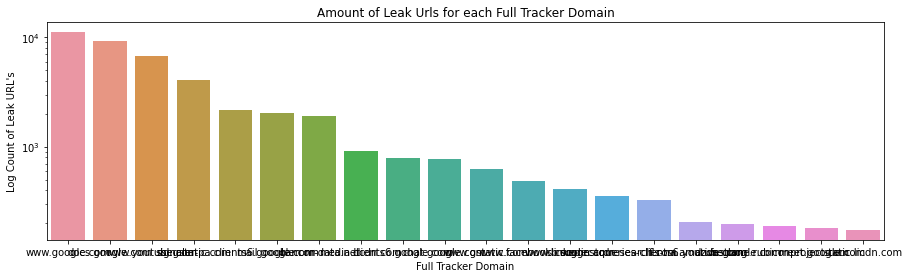

In [69]:
plt.figure().set_figwidth(15)
bp_full_tracker_count = sns.barplot(data = df_full_vs_leak1.head(20), x = 'Full Tracker Domain',y = 'Count').set(title = "Amount of Leak Urls for each Full Tracker Domain")
plt.yscale('log')
plt.ylabel("Log Count of Leak URL's")
plt.xticks(visible = True, )
plt.show()

This table shows the different leak urls we have found per each "full tracker domain"... We see the top 10, and see that 8 out of the top 10 are explictly google (Counting Youtube under the Google Domain) 

In [40]:
%timeit df_full_vs_leak1.head(20)

21.4 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [41]:
df_full_vs_leak1.shape

(341, 3)

#### Opening a Leak URL for example: "meet.google.com" to see what's happening

In [42]:
len1 = (df_full_vs_leak1["Full Tracker Domain"].values[3],len(df_full_vs_leak1["Leak URL"].values[3]),df_full_vs_leak1["Count"].values[3])
print(len1)

('ssl.gstatic.com', 4044, 4044)


In [43]:
data_ssl = df_full_vs_leak1["Leak URL"].values[5]

In [44]:
df_ssl = pd.DataFrame(data_ssl, columns = ["SSL GStatic"])
df_ssl.style.set_properties(**{'text-align': 'left'})
df_ssl

,SSL GStatic
0,https://mail.google.com/_/LEAKED_LASTNAME/LEAK...
1,https://mail.googlLEAKED_LASTNAME.com/_/LEAKED...
2,hLEAKED_LASTNAMELEAKED_LASTNAMEps://mail.googl...
3,https://mail.google.com/_/LEAKED_LASTNAME/LEAK...
4,https://mail.google.com/cloudsearch/request?hl...
...,...
2021,https://mail.google.com/_/LEAKED_LASTNAME/LEAK...
2022,https://mail.google.com/_/LEAKED_LASTNAME/LEAK...
2023,https://mail.google.com/mail/u/0/LEAKED_LASTNA...
2024,https://mail.google.com/cloudsearch/request?hl...


In [45]:
c = 0
print("Expanding to see the full URL: ")
for i in list(data_ssl)[1600:1700]: 
    if c == 10: 
        break
    print(i, "\n")
    c+=1 

Expanding to see the full URL: 
https://mail.google.com/mail/u/0/LEAKED_LASTNAME=2&ik=LEAKED_LASTNAME&LEAKED_LASTNAME=LEAKED_LASTNAME&LEAKED_LASTNAME=LEAKED_LASTNAME&rid=ad22..&auto=LEAKED_LASTNAME&LEAKED_LASTNAME=LEAKED_LASTNAME&LEAKED_LASTNAME=444064&LEAKED_LASTNAME=LEAKED_LASTNAME&LEAKED_LASTNAME=7LEAKED_LASTNAMELEAKED_LASTNAME7&mb=0&rt=LEAKED_LASTNAME 

https://mail.google.com/sync/u/0/i/bv?hl=en&c=50&rt=r&pt=ji 

https://mail.googlLEAKED_LASTNAME.com/_/LEAKED_LASTNAME/LEAKED_LASTNAME/_/js/k=gmail.main.LEAKED_LASTNAMEn.a_cDtaS_pbg.LEAKED_LASTNAMEs5.O/am=BgKoxP3gL-ERAhBBgIjsLEAKED_LASTNAME4G_BQ6WgC4chAK4ABBAAAMbqa7W-xMq6LEAKED_LASTNAMEAHJABAAHQcFQPGAQRhMw4PS0I4AwAmAAAAAAAAAAAAAAAAAAAAcJHyAw/d=LEAKED_LASTNAME/LEAKED_LASTNAMExm=LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKED_LASTNAME,LEAKE

### Now, what field types do the leak websites collect from the origin websites?
A next step in this analysis could be to connect what exactly leak websites collect data from these websites. When the user enters the origin website, the extension should trigger when any of their personal data is being leaked. I am now going to try and look furthur into this. It would be interesting to see if there is a relationship from websites where the leak is taking place, and what the tracker collects is of the leak website.  

### Let's build a repeatable method that we can call for a URL

In [46]:
filtered_data1[348279]

#Building a list of all the full Tracker domains
leakURL = []
leakTypes = []
cat = []
name = []
for i in filtered_data1: 
    rep = i['report']
    if rep.get('leak_url') != None: 
        leakURL.append(rep['leak_url'])
    else: leakURL.append("NA")
    if rep.get('tracker_info') != None: 
        if rep.get('tracker_info').get('tracker') != None: 
            if rep.get('tracker_info').get('tracker').get('categories') != None: 
                cat.append(rep['tracker_info']['tracker']['categories'])
            else: cat.append('NA')
            if rep.get('tracker_info').get('tracker').get('owner')!= None: 
                name.append(rep['tracker_info']['tracker']['owner']['name'])
            else: name.append("NA")
    else: 
        name.append("NA")
        cat.append("NA")
    if rep.get('url_leak_type') != None: 
        leakTypes.append(tuple(rep['url_leak_type']))
    else: leakTypes.append("NA")
               
df_company = pd.DataFrame.from_dict({'Name': name,'Leak URL': leakURL,'Leak Types': leakTypes, 'Cateogires': cat})

In [47]:
filtered_data1[239]['report']['tracker_info']['tracker']['categories']

['Ad Motivated Tracking', 'Advertising', 'Online Payment', 'Content Delivery']

In [48]:
comp_lists = [
    leakURL,
leakTypes,cat,
name]
for i in comp_lists: 
    print(len(i))

672634
672634
672634
672634


In [49]:
df_company = pd.DataFrame.from_dict({'Name': name,'Leak URL': leakURL,'Leak Types': leakTypes, 'Cateogires': tuple(cat)})

In [50]:
df_company.tail(20)

,Name,Leak URL,Leak Types,Cateogires
672614,"Facebook, Inc.",NA,NA,"[Ad Motivated Tracking, Advertising, Ad Fraud,..."
672615,Google LLC,NA,NA,"[Ad Motivated Tracking, Advertising, Online Pa..."
672616,Google LLC,NA,NA,"[Ad Motivated Tracking, Advertising, Online Pa..."
672617,"Amazon Technologies, Inc.",NA,NA,"[Ad Motivated Tracking, Analytics, SSO, Third-..."
672618,"Amazon Technologies, Inc.",NA,NA,"[Ad Motivated Tracking, Analytics, SSO, Third-..."
672619,"Amazon Technologies, Inc.",NA,NA,"[Ad Motivated Tracking, Analytics, SSO, Third-..."
672620,"Amazon Technologies, Inc.",NA,NA,"[Ad Motivated Tracking, Analytics, SSO, Third-..."
672621,"Facebook, Inc.",NA,NA,"[Ad Motivated Tracking, Advertising, Ad Fraud,..."
672622,Google LLC,NA,NA,"[Ad Motivated Tracking, Advertising, Online Pa..."
672623,Google LLC,NA,NA,"[Content Delivery, Embedded Content]"


In [51]:
def make_df_company(df): 
    d = {}
    for name, group in df.groupby('Name'):
        d['group_' + str(name)] = group
    new_df = pd.DataFrame.from_dict(d)

    return new_df

## Now, let's look at time. 
This data can also be viewed as time series. We can look into the start date which has time stamps. <br> Let's see how one JSON entry looks like again,

In [52]:
filtered_data1[239]['report']

{'user_id': None,
 'school_district': None,
 'grade': None,
 'request_method': 'POST',
 'timestamp': '2023-04-19T17:04:30.214Z',
 'leak_url': 'https://play.google.com/log?format=json&hasfast=true&authuser=1',
 'initiator_domain': 'https://docs.google.com/',
 'url_leak_type': ['lastname'],
 'body_leak_type': ['lastname'],
 'tracker_info': {'action': 'ignore',
  'reason': 'first party',
  'firstParty': True,
  'redirectUrl': False,
  'matchedRule': None,
  'matchedRuleException': False,
  'tracker': {'domain': 'google.com',
   'owner': {'name': 'Google LLC',
    'displayName': 'Google',
    'privacyPolicy': 'https://policies.google.com/privacy?hl=en&gl=us',
    'url': 'http://google.com'},
   'prevalence': 0.563,
   'fingerprinting': 3,
   'cookies': 0.057,
   'categories': ['Ad Motivated Tracking',
    'Advertising',
    'Online Payment',
    'Content Delivery'],
   'default': 'ignore',
   'rules': [{'rule': {}, 'fingerprinting': 3, 'cookies': 0},
    {'rule': {}, 'fingerprinting': 3, '

We are looking for ``timestamp`` in the json entries. Let's sort the json entries by that. 

In [53]:
filtered_data1[344]['report'].keys()

dict_keys(['user_id', 'school_district', 'grade', 'request_method', 'timestamp', 'leak_url', 'initiator_domain', 'url_leak_type', 'body_leak_type', 'tracker_info'])

In [54]:
timestamp_leak = {}
for i in filtered_data1: 
    a = i['report']['timestamp']
    timestamp_leak[a] = i

In [55]:
list(timestamp_leak.keys())[0:10]

['2023-04-19T15:09:48.101Z',
 '2023-04-19T15:09:48.103Z',
 '2023-04-19T15:09:48.240Z',
 '2023-04-19T15:11:25.738Z',
 '2023-04-19T15:11:25.741Z',
 '2023-04-19T15:11:25.895Z',
 '2023-04-19T15:14:48.478Z',
 '2023-04-19T15:14:48.613Z',
 '2023-04-19T15:14:53.784Z',
 '2023-04-19T15:15:22.395Z']

### Testing ways to convert timestamp data into a more readable format
Documentation on deciphering the results https://docs.python.org/3/library/datetime.html and
https://dateutil.readthedocs.io/en/stable/parser.html
#####   like a datetime object?

In [56]:
from dateutil.parser import parse

dt_obj =parse(list(timestamp_leak.keys())[0])
print(dt_obj, type(dt_obj))
#Z is UTC time zone 

2023-04-19 15:09:48.101000+00:00 <class 'datetime.datetime'>


In [57]:
from datetime import datetime
print(dt_obj.date(), "year: ", dt_obj.year, "month: ",dt_obj.month, "day: ", dt_obj.day)

2023-04-19 year:  2023 month:  4 day:  19


Okay, its working <3 <br>
Let's do a test/run through on some potential interesting data points so we can learn how to work with the data, and have a better understanding of what we are working with. I think an initial interesting one would be to test number of entries based on month? or produce a graph of time series with counts of entries. First thought is to do my favourite - a dictionairy - where the key is a unique year + month + day, and the value will add the entries. <br>
Let's work with building the keys first, 

In [58]:
dict_timestamps = {}
for i in list(timestamp_leak.keys()): 
    dtObj = parse(i)
    ke = str(dtObj.year) + "/" + str(dtObj.month) + "/" + str(dtObj.day)
    #checking if there is an entry 
    
    if ke in dict_timestamps:    
        dict_timestamps[ke] +=1 
    else: 
        dict_timestamps[ke] = 1
print(len(dict_timestamps.keys()))

45


#### Building dataframe immediately from dictionairy then writing it into a nice barchart

In [59]:
df_timestamps = pd.DataFrame.from_dict({"Timestamps": list(dict_timestamps.keys()),"Count": list(dict_timestamps.values())})
df_timestamps.head(100)

,Timestamps,Count
0,2023/4/19,2778
1,2023/4/20,5206
2,2023/4/21,7108
3,2023/4/22,2634
4,2023/4/23,1380
5,2023/4/24,64104
6,2023/4/25,127556
7,2023/4/26,9667
8,2023/4/27,5568
9,2023/4/28,21447


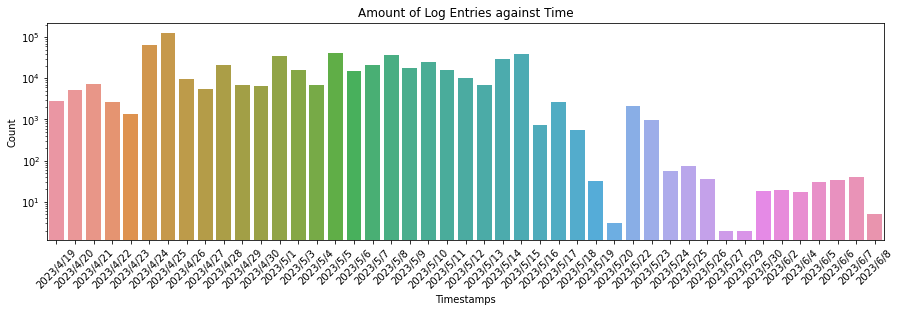

In [60]:
plt.figure().set_figwidth(15)

barplot_time = sns.barplot(data = df_timestamps, x = 'Timestamps',y = 'Count').set(title = "Amount of Log Entries against Time")
plt.yscale('log')
plt.xticks(rotation= 45)
plt.show()

In [61]:
df_timestamps.shape

(45, 2)

### Now, it would be interesting to also see what users usage over time

In [62]:
df_june = df_timestamps.iloc[38:]
df_june

,Timestamps,Count
38,2023/5/30,18
39,2023/6/2,19
40,2023/6/4,17
41,2023/6/5,30
42,2023/6/6,33
43,2023/6/7,40
44,2023/6/8,5


In [63]:
a = []
b = []
for i in filtered_data1: 
    a.append(i.get('report')['user_id'])
    dtObj = parse(i['report']['timestamp'])
    ke = str(dtObj.year) + "/" + str(dtObj.month) + "/" + str(dtObj.day)
    b.append(ke)
    
df_n = pd.DataFrame.from_dict({'User_ID': a,'Timestamps': b})
df_n
#grouped_df = df_leak_origin_urls.groupby('Origin URLS')['Leak URLS'].apply(set).reset_index(name = "Leak URLS")

,User_ID,Timestamps
0,None,2023/4/19
1,None,2023/4/19
2,None,2023/4/19
3,None,2023/4/19
4,None,2023/4/19
...,...,...
672629,4q68v2cg2pl,2023/5/25
672630,jktgjnvw8r,2023/5/30
672631,4q68v2cg2pl,2023/6/5
672632,s4ni7dbb7y,2023/6/7


### Now, grouping by day, and adding a count of how many times the user appears
Time stamps, User_ID, How many times User_ID appears per day

In [64]:
_grouped_user = df_n.groupby(['Timestamps', 'User_ID']).size()
df_grouped_user = _grouped_user.to_frame(name = 'Count').reset_index()
df_grouped_user.head(20)

,Timestamps,User_ID,Count
0,2023/4/25,2wpdvj73oou,120917
1,2023/4/25,9tgpozqqg7d,41
2,2023/4/25,d1wgiodc53k,724
3,2023/4/25,zoumk7kg3yq,148
4,2023/4/25,zwq78tx53ib,74
5,2023/4/26,9tgpozqqg7d,83
6,2023/4/27,zoumk7kg3yq,7
7,2023/4/28,s4ni7dbb7y,24563
8,2023/4/29,s4ni7dbb7y,7834
9,2023/4/30,5tpckk3d14e,53


In [65]:
df_grouped_user1 = df_grouped_user.set_index(['Timestamps', 'User_ID'])
df_grouped_user2 = df_grouped_user1.reset_index().sort_values(['Timestamps', 'Count'], ascending = [True, False]).set_index(['Timestamps', 'User_ID'])
df_grouped_user2.head(40)

Count
Timestamps User_ID            
2023/4/25  2wpdvj73oou  120917
           d1wgiodc53k     724
           zoumk7kg3yq     148
           zwq78tx53ib      74
           9tgpozqqg7d      41
2023/4/26  9tgpozqqg7d      83
2023/4/27  zoumk7kg3yq       7
2023/4/28  s4ni7dbb7y    24563
2023/4/29  s4ni7dbb7y     7834
2023/4/30  s4ni7dbb7y     7319
           5tpckk3d14e      53
2023/5/1   s4ni7dbb7y    40870
2023/5/10  zu7pjmkeoi    18803
           4485kqex0zs    5888
           dknglbh1h3     4068
           9tgpozqqg7d    2774
           699mztw4z75      56
           80yfsk3rrlc      56
2023/5/11  zu7pjmkeoi    11662
           4485kqex0zs    8371
           9tgpozqqg7d      19
2023/5/12  zu7pjmkeoi     6810
           4485kqex0zs    5296
2023/5/13  zu7pjmkeoi     8714
           4485kqex0zs     222
2023/5/14  zu7pjmkeoi    19506
           4485kqex0zs   14040
2023/5/15  4485kqex0zs   23564
           zu7pjmkeoi    20218
2023/5/16  zu7pjmkeoi      764
2023/5/17  zu7pjmkeoi     3103
           4q68v2cg2pl       5
2023/5/18  zu7pjmkeoi      661
           4q68v2cg2pl       9
2023/5/19  4485kqex0zs      27
           4q68v2cg2pl       5
2023/5/20  4q68v2cg2pl       2
           4485kqex0zs       1
2023/5/22  zu7pjmkeoi     2413
           4q68v2cg2pl       9

## Now, plotting this with the graph
#learn multithreading 

## Now, lets connect everything with user
**Question** --> would it be more useful to use filtered_data or filtered_data1. Where the first removes reports with "none" as a user_id, or the second where it only removes entries that do not record an origin website. As this is a more user centric approach, would moving back to fitlered_data be more appropriate? Or does this hinder our exploration by sort of confusing what we are seeing

In [66]:
list_user = []
for i in filtered_data1: 
    a = i.get('report')['user_id']
    list_user.append(a)
print(f'There are in total {len(list_user)} entries of multiple users, and {len(set(list_user))} unique users')

There are in total 672634 entries of multiple users, and 20 unique users


In [67]:
%%capture captured_output -o
dict_user = simple_produce_count(list_user)
df_users = pd.DataFrame.from_dict({"Users": list(dict_user.keys()),"Appearances": list(dict_user.values())})
df_users

UsageError: unrecognized arguments: -o


In [ ]:
%%writefile output.txt
print(captured_output.stdout)